#### Import Libraries

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, classification_report)

In [3]:
# Loading the data into the notebook
np.random.seed(42)
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# Loading the data into a pandas dataframe
cancer_df = pd.DataFrame(cancer['data'], columns= cancer['feature_names'])
cancer_df['target'] = cancer['target']
cancer_temp = cancer_df.sample(frac=1)

In [4]:
# Overview of the data
cancer_df.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [5]:
x = cancer_df.drop(["target"],axis=1) 
y = cancer_df[['target']]

In [6]:
# Splitting Data into Training and Test sets 

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

#### Pipelines with and without PCA

In [7]:
pipelines = {
    "LogReg_NoPCA": Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000))
    ]),
    
    "LogReg_PCA": Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('model', LogisticRegression(max_iter=1000))
    ]),
    
    "SVM_NoPCA": Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(probability=True))
    ]),
    
    "SVM_PCA": Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('model', SVC(probability=True))
    ]),
    
    "KNN_NoPCA": Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier())
    ]),
    
    "KNN_PCA": Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('model', KNeighborsClassifier())
    ])
}

#### Hyper parameter grids

In [8]:
param_grids = {
    "LogReg_NoPCA": {
        'model__C': [0.01, 0.1, 1, 10]
    },
    
    "LogReg_PCA": {
        'pca__n_components': [0.90, 0.95, 0.99],
        'model__C': [0.01, 0.1, 1, 10]
    },
    
    "SVM_NoPCA": {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['rbf', 'linear']
    },
    
    "SVM_PCA": {
        'pca__n_components': [0.90, 0.95, 0.99],
        'model__C': [0.1, 1, 10],
        'model__kernel': ['rbf', 'linear']
    },
    
    "KNN_NoPCA": {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance']
    },
    
    "KNN_PCA": {
        'pca__n_components': [0.90, 0.95, 0.99],
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance']
    }
}

In [9]:
results = []

for name, pipeline in pipelines.items():
    print(f"\n================ {name} =================")

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring='roc_auc',
        cv=5,
        n_jobs=-1
    )

    grid.fit(xtrain, ytrain)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(xtest)
    y_prob = best_model.predict_proba(xtest)[:, 1]

    print("Best Parameters:")
    print(grid.best_params_)

    print("\nClassification Report:")
    print(classification_report(ytest, y_pred))

    # Safely check for PCA
    pca_step = best_model.named_steps.get('pca', None)

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(ytest, y_pred),
        "Precision": precision_score(ytest, y_pred),
        "Recall": recall_score(ytest, y_pred),
        "F1-score": f1_score(ytest, y_pred),
        "ROC-AUC": roc_auc_score(ytest, y_prob),
        "PCA_Used": pca_step is not None,
        "PCA_Components": pca_step.n_components_ if pca_step else "N/A"
    }

    results.append(metrics)



================ LogReg_NoPCA =================


C:\Users\josep\anaconda3\envs\mlenv2\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters:
{'model__C': 0.1}

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


================ LogReg_PCA =================


C:\Users\josep\anaconda3\envs\mlenv2\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters:
{'model__C': 1, 'pca__n_components': 0.9}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        42
           1       0.97      0.94      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114


================ SVM_NoPCA =================


C:\Users\josep\anaconda3\envs\mlenv2\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters:
{'model__C': 10, 'model__kernel': 'rbf'}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


================ SVM_PCA =================


C:\Users\josep\anaconda3\envs\mlenv2\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters:
{'model__C': 10, 'model__kernel': 'rbf', 'pca__n_components': 0.95}

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        42
           1       0.99      0.96      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114


================ KNN_NoPCA =================


C:\Users\josep\anaconda3\envs\mlenv2\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\josep\anaconda3\envs\mlenv2\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Best Parameters:
{'model__n_neighbors': 9, 'model__weights': 'distance'}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        42
           1       0.96      1.00      0.98        72

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114


================ KNN_PCA =================
Best Parameters:
{'model__n_neighbors': 9, 'model__weights': 'distance', 'pca__n_components': 0.99}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        42
           1       0.96      1.00      0.98        72

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



C:\Users\josep\anaconda3\envs\mlenv2\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [10]:
# Display results
print("\n============= SUMMARY OF RESULTS ======\n")
results_df = pd.DataFrame(results)
results_df


============= SUMMARY OF RESULTS ======



,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC,PCA_Used,PCA_Components
0,LogReg_NoPCA,0.973684,0.972603,0.986111,0.979310,0.995701,False,N/A
1,LogReg_PCA,0.947368,0.971429,0.944444,0.957746,0.993717,True,7
2,SVM_NoPCA,0.973684,0.985915,0.972222,0.979021,0.995701,False,N/A
3,SVM_PCA,0.964912,0.985714,0.958333,0.971831,0.994048,True,10
4,KNN_NoPCA,0.973684,0.960000,1.000000,0.979592,0.993386,False,N/A
5,KNN_PCA,0.973684,0.960000,1.000000,0.979592,0.991733,True,17


C:\Users\josep\anaconda3\envs\mlenv2\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\josep\anaconda3\envs\mlenv2\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\josep\anaconda3\envs\mlenv2\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\josep\anaconda3\envs\mlenv2\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expec

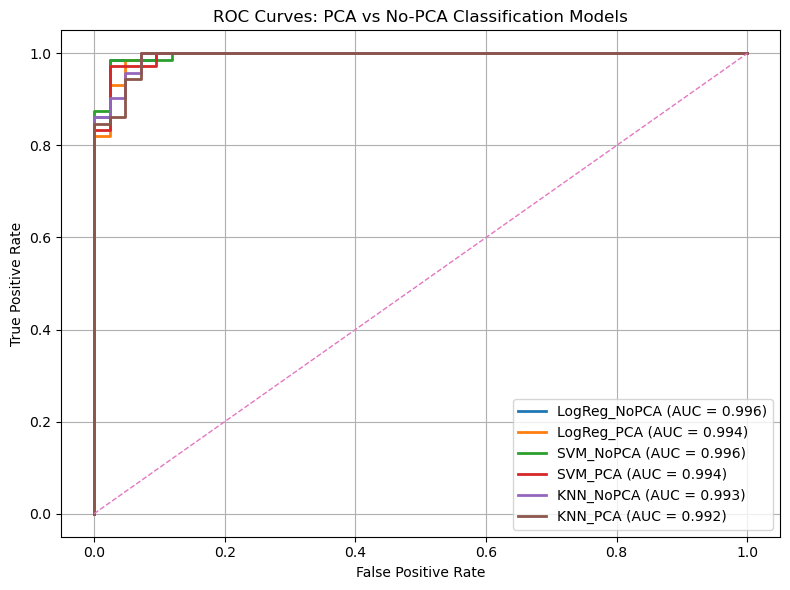

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for name, pipeline in pipelines.items():

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring='roc_auc',
        cv=5,
        n_jobs=-1
    )

    grid.fit(xtrain, ytrain)
    best_model = grid.best_estimator_

    y_prob = best_model.predict_proba(xtest)[:, 1]

    # ROC curve
    fpr, tpr, _ = roc_curve(ytest, y_prob)
    roc_auc = auc(fpr, tpr)

    label = f"{name} (AUC = {roc_auc:.3f})"
    plt.plot(fpr, tpr, linewidth=2, label=label)

# Reference line
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: PCA vs No-PCA Classification Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


##### Cluster visualization (2D PCA)

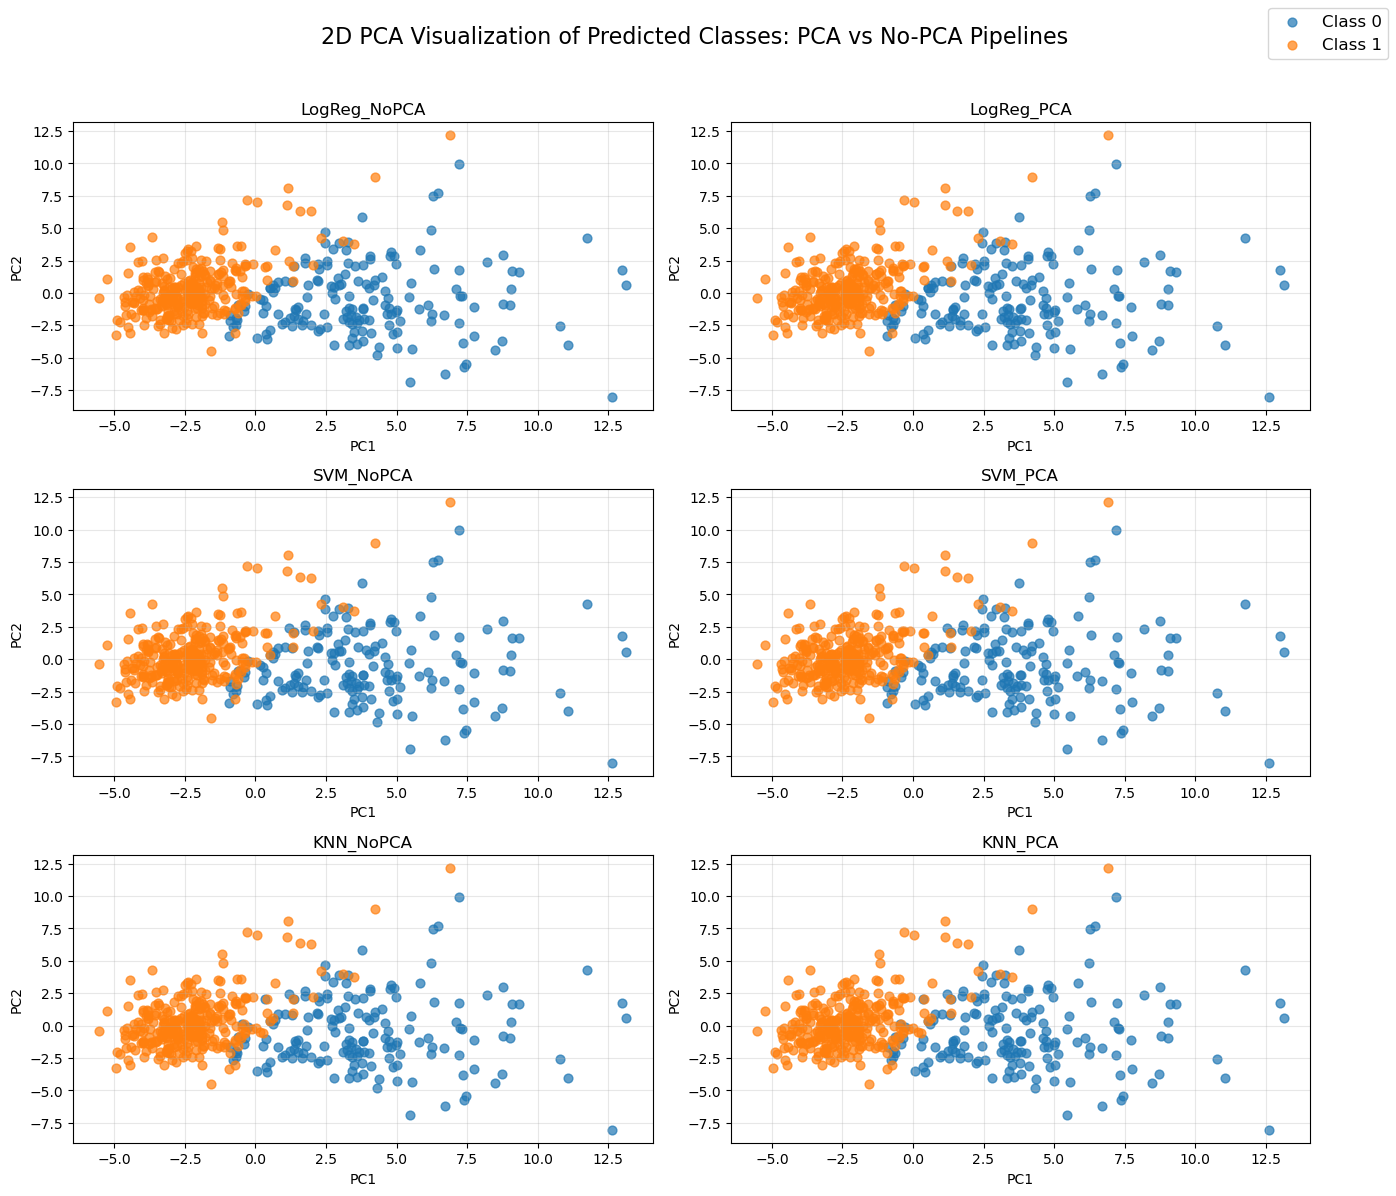

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Function for plotting a single subplot
def plot_subplot(ax, X, y_pred, title):
    """
    Plot PCA 2D projection on a specific subplot.
    """
    unique_classes = np.unique(y_pred)
    for cls in unique_classes:
        mask = y_pred == cls
        ax.scatter(
            X[mask, 0],
            X[mask, 1],
            s=40,
            alpha=0.7,
            label=f"Class {cls}"
        )
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("PC1", fontsize=10)
    ax.set_ylabel("PC2", fontsize=10)
    ax.grid(alpha=0.3)

# Prepare figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,12))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# Row / column mapping
model_order = ["LogReg", "SVM", "KNN"]
pipeline_types = ["NoPCA", "PCA"]

# Loop through rows (models)
for i, model_name in enumerate(model_order):
    for j, pca_type in enumerate(pipeline_types):
        pipeline_key = f"{model_name}_{pca_type}"
        pipeline = pipelines[pipeline_key]
        
        # Fit pipeline
        pipeline.fit(xtrain, ytrain.values.ravel())
        y_pred = pipeline.predict(xtrain)
        
        # Transform features for 2D plotting
        if 'pca' in pipeline.named_steps:
            X_viz = pipeline.named_steps['pca'].transform(
                pipeline.named_steps['scaler'].transform(xtrain)
            )
        else:
            # No-PCA: scale then temporary PCA for 2D plot
            X_scaled = pipeline.named_steps['scaler'].transform(xtrain)
            X_viz = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
        
        # Plot in correct subplot
        plot_subplot(axes[i,j], X_viz, y_pred, title=pipeline_key)

# Add common legend
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=12)

plt.suptitle("2D PCA Visualization of Predicted Classes: PCA vs No-PCA Pipelines", fontsize=16)
plt.tight_layout(rect=[0,0,0.95,0.96])
plt.show()


#### PCA Loadings

In [22]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(xtrain)

# Fit PCA (use same n_components as best model)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)


In [23]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=xtrain.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
mean radius,0.217636,-0.238698,-0.003253,-0.037402,0.045752,0.017565,-0.092948,0.038815,0.216530,0.088418
mean texture,0.095485,-0.066463,0.069831,0.601827,-0.082470,-0.027608,-0.020767,0.136995,-0.163750,0.207270
mean perimeter,0.226435,-0.219569,-0.004272,-0.038242,0.044420,0.015805,-0.085071,0.025900,0.222072,0.078271
mean area,0.219862,-0.233778,0.030472,-0.051231,0.019193,-0.010955,-0.036567,0.073975,0.186486,0.089696
mean smoothness,0.148544,0.176462,-0.109980,-0.173798,-0.345732,-0.287157,-0.121382,-0.288729,0.025386,-0.037835


#### Insight

The PCA loadings matrix quantifies how strongly each original feature contributes to each principal component (PC).
PCA loadings describe variance structure, not predictive relevance. The PCA loading structure reveals that the dominant sources of variance in the dataset are driven primarily by highly correlated geometric features such as radius, perimeter, and area, which collectively define a global tumor size axis. While these features account for substantial variance, their redundancy limits their discriminative utility. 

In [24]:
# Aggregate absolute loadings across components
feature_importance = loadings.abs().mean(axis=1)

# Rank features
feature_importance = feature_importance.sort_values(ascending=False)

feature_importance.head(10)

smoothness error           0.226040
symmetry error             0.225956
mean symmetry              0.217510
texture error              0.216454
worst smoothness           0.183687
fractal dimension error    0.175661
mean smoothness            0.171501
worst symmetry             0.171266
concave points error       0.161284
concavity error            0.158468
dtype: float64

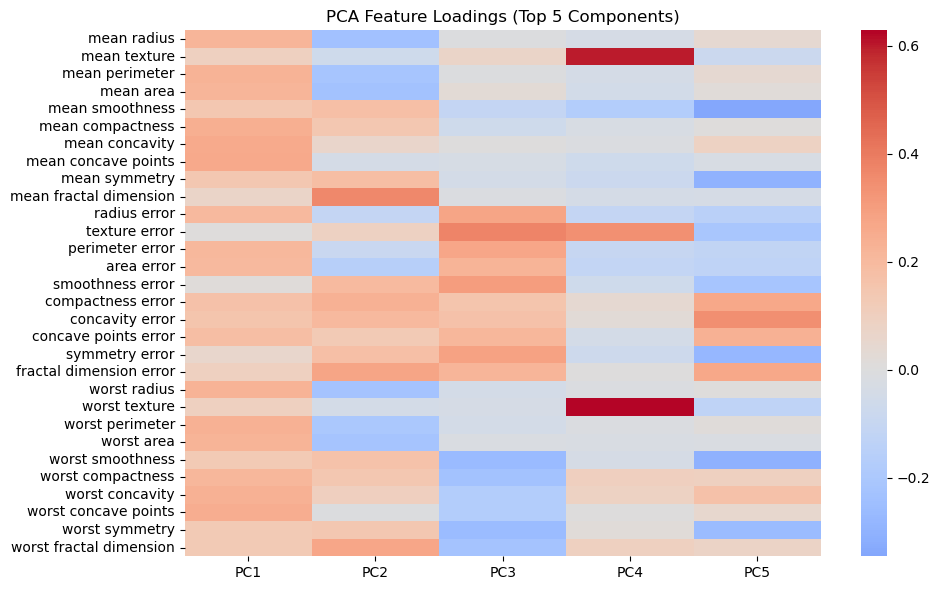

In [25]:
plt.figure(figsize=(10,6))
sns.heatmap(loadings.iloc[:, :5], cmap="coolwarm", center=0)
plt.title("PCA Feature Loadings (Top 5 Components)")
plt.tight_layout()
plt.show()

##### Insight

Although PCA does not explicitly select features, the contribution of original variables to the transformed feature space can be inferred from component loadings. In this study, features with higher absolute loadings contributed more strongly to the principal components retained for modeling. However, the application of PCA resulted in reduced predictive performance across all evaluated models, indicating that low-variance features suppressed during dimensionality reduction contained important predictive information. This highlights a key limitation of unsupervised dimensionality reduction in supervised learning tasks.

##### PCA Feature Contribution (Variance-based)

In [29]:
# Extract steps
scaler = best_model.named_steps['scaler']
pca = best_model.named_steps['pca']
model = best_model.named_steps['model']

# Transform training data exactly as model saw it
X_train_scaled = scaler.transform(xtrain)
X_train_pca = pca.transform(X_train_scaled)

In [30]:
explainer = shap.KernelExplainer(
    model.predict_proba,
    X_train_pca[:100]  # background in PCA space
)

shap_values = explainer(X_train_pca)

# Binary classification → class 1
shap_vals = shap_values.values
if shap_vals.ndim == 3:
    shap_vals = shap_vals[:, :, 1]

shap_importance_pca = np.abs(shap_vals).mean(axis=0)

shap_importance_pca = pd.Series(
    shap_importance_pca,
    index=[f"PC{i+1}" for i in range(X_train_pca.shape[1])],
    name="SHAP_importance_PCA"
)

print(shap_importance_pca.head())

  0%|          | 0/455 [00:00<?, ?it/s]

PC1    0.373101
PC2    0.052877
PC3    0.028094
PC4    0.028744
PC5    0.013121
Name: SHAP_importance_PCA, dtype: float64


In [31]:
# PCA loadings
pca_loadings = pd.DataFrame(
    pca.components_.T,
    index=xtrain.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Aggregate absolute loadings per PC
pca_loading_strength = pca_loadings.abs().mean(axis=0)

comparison = pd.concat(
    [pca_loading_strength.rename("Avg_Loading_Magnitude"),
     shap_importance_pca],
    axis=1
)

print(comparison.head(10))


      Avg_Loading_Magnitude  SHAP_importance_PCA
PC1                0.168363             0.373101
PC2                0.164299             0.052877
PC3                0.145176             0.028094
PC4                0.101494             0.028744
PC5                0.145063             0.013121
PC6                0.104682             0.009822
PC7                0.142294             0.004499
PC8                0.136256             0.004053
PC9                0.160268             0.004674
PC10               0.127465             0.002637


##### Insight

The comparison between average PCA loading magnitude and SHAP importance reveals a pronounced divergence between variance explanation and predictive contribution. While several principal components exhibit substantial loading magnitudes, only the first component meaningfully influences model predictions. The remaining components, despite capturing nontrivial variance, contribute negligibly to classification performance.

In [33]:
from scipy.stats import pearsonr, spearmanr

# Aggregate PCA loading magnitude per PC
pca_loading_strength = pca_loadings.abs().mean(axis=0)

# Align indices
comparison_df = pd.concat(
    [
        pca_loading_strength.rename("PCA_Loading_Strength"),
        shap_importance_pca.rename("SHAP_Importance")
    ],
    axis=1
).dropna()

# Pearson (linear relationship)
pearson_corr, pearson_p = pearsonr(
    comparison_df["PCA_Loading_Strength"],
    comparison_df["SHAP_Importance"]
)

# Spearman (rank-based relationship)
spearman_corr, spearman_p = spearmanr(
    comparison_df["PCA_Loading_Strength"],
    comparison_df["SHAP_Importance"]
)

print("PCA vs SHAP Correlation Statistics")
print("---------------------------------")
print(f"Pearson r   = {pearson_corr:.3f} (p = {pearson_p:.3e})")
print(f"Spearman ρ = {spearman_corr:.3f} (p = {spearman_p:.3e})")


PCA vs SHAP Correlation Statistics
---------------------------------
Pearson r   = 0.401 (p = 1.110e-01)
Spearman ρ = 0.282 (p = 2.731e-01)


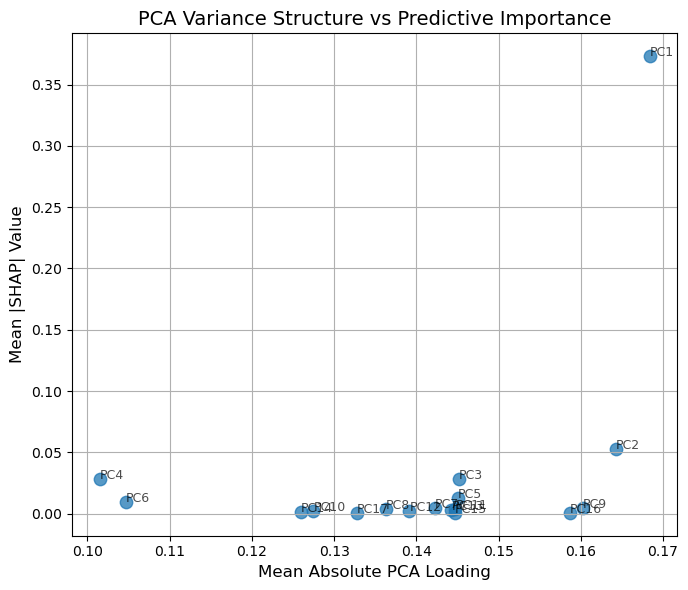

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
plt.scatter(
    comparison_df["PCA_Loading_Strength"],
    comparison_df["SHAP_Importance"],
    s=80,
    alpha=0.75
)

# Annotate PCs
for pc in comparison_df.index:
    plt.annotate(
        pc,
        (comparison_df.loc[pc, "PCA_Loading_Strength"],
         comparison_df.loc[pc, "SHAP_Importance"]),
        fontsize=9,
        alpha=0.7
    )

plt.xlabel("Mean Absolute PCA Loading", fontsize=12)
plt.ylabel("Mean |SHAP| Value", fontsize=12)
plt.title("PCA Variance Structure vs Predictive Importance", fontsize=14)

plt.grid(True)
plt.tight_layout()
plt.show()


#### Insight

This graph demonstrates a pronounced decoupling between variance explanation and predictive relevance. While several principal components exhibit substantial loading magnitudes, only PC1 meaningfully influences model predictions. The remaining components, despite capturing nontrivial variance, contribute negligibly to decision-making. These findings empirically confirm that PCA preserves dominant data structure rather than discriminative structure, and that variance-maximizing components beyond the first may act primarily as predictive noise.

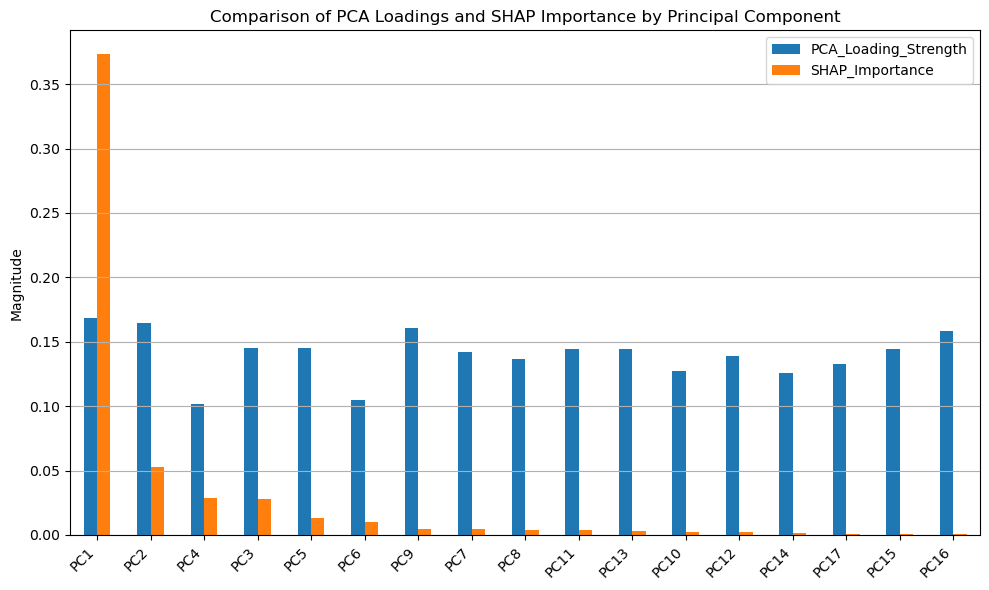

In [35]:
#Ranked Comparison Bar Chart

comparison_df_sorted = comparison_df.sort_values(
    "SHAP_Importance", ascending=False
)

comparison_df_sorted.plot(
    kind="bar",
    figsize=(10, 6)
)

plt.ylabel("Magnitude")
plt.title("Comparison of PCA Loadings and SHAP Importance by Principal Component")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


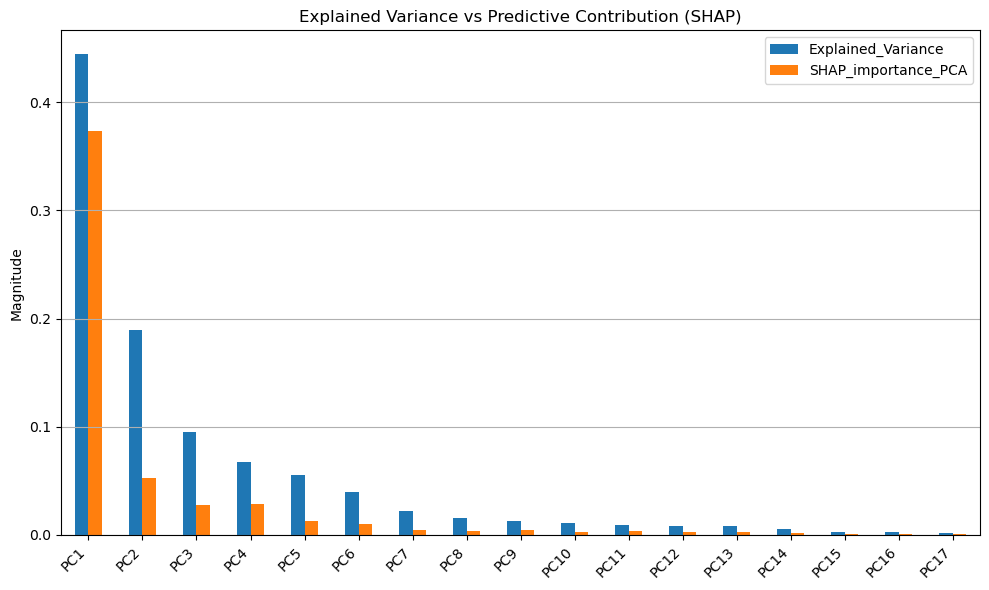

In [36]:
explained_variance = pd.Series(
    pca.explained_variance_ratio_,
    index=comparison_df.index,
    name="Explained_Variance"
)

variance_shap_df = pd.concat(
    [explained_variance, shap_importance_pca],
    axis=1
)

variance_shap_df.plot(
    kind="bar",
    figsize=(10, 6)
)

plt.ylabel("Magnitude")
plt.title("Explained Variance vs Predictive Contribution (SHAP)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()
